In [1]:
import sys
sys.path.append('/home/xinyiz/pamrats')

import time
import os

import scanpy
import numpy as np
import scipy.sparse as sp

import torch
from torch import optim

# from sklearn.metrics import roc_auc_score
# from sklearn.metrics import average_precision_score

import gae.gae.optimizer as optimizer
import gae.gae.model
import gae.gae.preprocessing as preprocessing

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import pandas as pd
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN,MiniBatchKMeans,AgglomerativeClustering
from sklearn import metrics
from sklearn.linear_model import LogisticRegression


In [18]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1" 
ifplot=True
ifcluster=True

logitL1=0.1 #smaller is sparser
geneThresh=2.5 #times std above mean

inverseAct='leakyRelu'
# inverseAct=None
plottype='umap'
pca=PCA()
minCells=15 #min number of cells for analysis
minCell_clusterDE=5
# clustermethod=['kmeanbatch']
clustermethod=['kmeanbatch']
#umap/leiden clustering parameters
n_neighbors=10
min_dist=0.25
n_pcs=40 #for clustering
# resolution=[0.5,1,1.5,2]
resolution=[0.05,0.1,0.2,0.3]
plotepoch=9990
savenameAdd=''
#DBscan
epslist= [6,8,10]
min_sampleslist=[15,30,45] 
#agglomerative
nclusterlist=[3]
# nclusterlist=[2,3,4,5,8,10]
aggMetric=['euclidean']


combineCelltype={'glia':['Astro','Micro', 'OPC', 'Oligo'],'CA':['CA1', 'CA2', 'CA3']}

use_cuda=True
fastmode=False #Validate during training pass
seed=3
useSavedMaskedEdges=False
maskedgeName='knn20_connectivity'
hidden1=1024 #Number of units in hidden layer 1
hidden2=1024 #Number of units in hidden layer 2
# hidden3=16
fc_dim1=1024
# fc_dim2=2112
# fc_dim3=2112
# fc_dim4=2112
# gcn_dim1=2048

protein=None #'scaled_binary'
# proteinWeights=0.05
dropout=0.01
# randFeatureSubset=None
model_str='gcn_vae_xa_e2_d1_dca'
adj_decodeName=None #gala or None
plot_samples={'disease13':'AD_mouse9494','control13':'AD_mouse9498','disease8':'AD_mouse9723','control8':'AD_mouse9735'}
plot_sample_X=['logminmax']
plotRecon='' #'meanRecon'
# plot_sample_X=['corrected','scaled']
standardizeX=False
name='allk20XA_01_dca'
logsavepath='/mnt/xinyi/pamrats/log/train_gae_starmap/'+name
modelsavepath='/mnt/xinyi/pamrats/models/train_gae_starmap/'+name
plotsavepath='/mnt/xinyi/pamrats/plots/train_gae_starmap/'+name
    

In [3]:
# Set cuda and seed
np.random.seed(seed)
if use_cuda and (not torch.cuda.is_available()):
    print('cuda not available')
    use_cuda=False
torch.manual_seed(seed)
if use_cuda:
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.enabled = True


In [4]:
#Load data
savedir=os.path.join('/mnt/xinyi/','starmap')
adj_dir=os.path.join(savedir,'a')

featureslist={}
if plot_sample_X[0] in ['corrected','scaled']:
    scaleddata=scanpy.read_h5ad('/mnt/xinyi/2021-01-13-mAD-test-dataset/2020-12-27-starmap-mAD-scaled.h5ad')
    
    for s in plot_samples.keys():
        featureslist[s+'X_'+'corrected']=torch.tensor(scaleddata.layers['corrected'][scaleddata.obs['sample']==plot_samples[s]])
        featureslist[s+'X_'+'scaled']=torch.tensor(scaleddata.layers['scaled'][scaleddata.obs['sample']==plot_samples[s]])
    
else:
    scaleddata=scanpy.read_h5ad('/mnt/xinyi/2021-01-13-mAD-test-dataset/2020-12-27-starmap-mAD-raw.h5ad')
    
    for s in plot_samples.keys():
        scaleddata_train=scaleddata.X[scaleddata.obs['sample']==plot_samples[s]]

        if plot_sample_X[0]=='logminmax':
            featurelog_train=np.log2(scaleddata_train+1/2)
            scaler = MinMaxScaler()
            featurelog_train_minmax=np.transpose(scaler.fit_transform(np.transpose(featurelog_train)))
            featureslist[s+'X_'+plot_sample_X[0]]=torch.tensor(featurelog_train_minmax)

for s in plot_samples.keys():
    featureslist[s+'X_'+plot_sample_X[0]].requires_grad=True
    
if protein: ##adjust for scaled/corrected
    proteinsavepath=os.path.join('/mnt/xinyi/','starmap','protein')
    for s in plot_samples.keys():
        pmtx=sp.load_npz(os.path.join(proteinsavepath,plot_samples[s]+'_'+protein+'.npz'))
        pmtx=preprocessing.sparse_mx_to_torch_sparse_tensor(pmtx)
        pmtx=pmtx.to_dense()
        scalefactor=torch.sum(featureslist[s+'X_'+plot_sample_X[0]])/torch.sum(pmtx)*proteinWeights
        featureslist[s+'X_'+plot_sample_X[0]]=torch.cat((featureslist[s+'X_'+plot_sample_X[0]],pmtx*scalefactor),dim=1)

adj_list={}
adj_list['disease13']=sp.load_npz(os.path.join(adj_dir,maskedgeName+'_AD_mouse9494.npz'))
adj_list['control13']=sp.load_npz(os.path.join(adj_dir,maskedgeName+'_AD_mouse9498.npz'))
adj_list['disease8']=sp.load_npz(os.path.join(adj_dir,maskedgeName+'_AD_mouse9723.npz'))
adj_list['control8']=sp.load_npz(os.path.join(adj_dir,maskedgeName+'_AD_mouse9735.npz'))

feature_names=scaleddata.var.index
feature_names=feature_names.astype(str)

In [5]:
# load model
num_nodes,num_features = list(featureslist.values())[0].shape
if model_str=='gcn_vae_xa':
    model  = gae.gae.model.GCNModelVAE_XA(num_features, hidden1, hidden2,fc_dim1,fc_dim2,fc_dim3,fc_dim4, dropout)
elif model_str=='fc1':
    model  = gae.gae.model.FCVAE1(num_features, hidden1,dropout)
elif model_str == 'gcn_vae_xa_e2_d1':
    model  = gae.gae.model.GCNModelVAE_XA_e2_d1(num_features, hidden1,hidden2, dropout)
elif model_str == 'gcn_vae_gcnX_inprA':
    model = gae.gae.model.GCNModelVAE_gcnX_inprA(num_features, hidden1, hidden2,gcn_dim1, dropout)
elif model_str=='fc1_dca':
    model = gae.gae.model.FCVAE1_DCA(num_features, hidden1,fc_dim1, dropout)
elif model_str=='gcn_vae_xa_e2_d1_dca':
    model = gae.gae.model.GCNModelVAE_XA_e2_d1_DCA(num_features, hidden1,hidden2,fc_dim1, dropout)
elif model_str=='gcn_vae_xa_e2_d1_dcaFork':
    model = gae.gae.model.GCNModelVAE_XA_e2_d1_DCAfork(num_features, hidden1,hidden2,fc_dim1, dropout)
elif model_str=='gcn_vae_xa_e2_d1_dcaElemPi':
    model = gae.gae.model.GCNModelVAE_XA_e2_d1_DCAelemPi(num_features, hidden1,hidden2,fc_dim1, dropout,shareGenePi)
elif model_str=='gcn_vae_xa_e2_d1_dcaConstantDisp':
    model = gae.gae.model.GCNModelVAE_XA_e2_d1_DCA_constantDisp(num_features, hidden1,hidden2,fc_dim1, dropout,shareGenePi)
else:
    print('model not found')
model.load_state_dict(torch.load(os.path.join(modelsavepath,str(plotepoch)+'.pt')))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [6]:
np.random.seed(seed)
def inverseLeakyRelu(v,slope=0.01):
    vnegidx=(v<0)
    v[vnegidx]=1/slope*v[vnegidx]
    return v

In [7]:
#compute embeddings
mulist={}
for s in plot_samples.keys():
    adj=adj_list[s]
    adj_norm = preprocessing.preprocess_graph(adj)
    adj_decode=None
    if adj_decodeName == 'gala':
        adj_decode=preprocessing.preprocess_graph_sharp(adj)
    for xcorr in plot_sample_X:
        samplename=s+'X_'+xcorr
        features=featureslist[samplename]
        if standardizeX:
            features=torch.tensor(scale(features,axis=0, with_mean=True, with_std=True, copy=True))
        if use_cuda:
            model.cuda()
            features = features.cuda().float()
            adj_norm=adj_norm.cuda()
            if adj_decodeName:
                adj_decode=adj_decode.cuda()
        
        model.eval()
        if adj_decodeName==None:
            adj_recon,mu,logvar,z, features_recon = model(features, adj_norm)
        else:
            adj_recon,mu,logvar,z, features_recon = model(features, adj_norm,adj_decode)
        if inverseAct=='leakyRelu':
            muplot=inverseLeakyRelu(mu)
        else:
            muplot=mu
        if plotRecon:
            if plotRecon=='meanRecon':
                mulist[samplename]=features_recon[3].cpu().detach().numpy()
        else:
            mulist[samplename]=muplot
        

In [8]:
def getDiffActivation(cbyf,cidx,labels,savepath):
    
    res=np.array([])
    for l in np.unique(labels):
        if l==-1:
            continue
        if np.sum(labels==l)<minCell_clusterDE or np.sum(labels!=l)<minCell_clusterDE:
            continue
        
        labels_l=np.where(labels==l,1,0)
        logitl=LogisticRegression(C=logitL1, penalty='l1', solver='saga',multi_class='ovr',max_iter=1000,fit_intercept=False)
        logitl.fit(cbyf.cpu().detach().numpy()[cidx], labels_l)
        coeffl=np.flatnonzero(logitl.coef_)
#         print(coeffl)
        if coeffl.size>0:
            with open(os.path.join(savepath,str(l)+'da'), 'wb') as output:
                pickle.dump(coeffl, output, pickle.HIGHEST_PROTOCOL)
            np.savetxt(os.path.join(savepath,str(l)+'DA.csv'), coeffl, delimiter=",")
            res=np.concatenate((res,coeffl))
    if res.size==0:
        return res
    res=np.unique(res)
    if savepath:
        with open(os.path.join(savepath,'da'), 'wb') as output:
            pickle.dump(res, output, pickle.HIGHEST_PROTOCOL)
    print(res.size)
    return res.astype(int)

def filterColbySTD(mtx,thresh):
    mtxMean=np.mean(mtx,axis=1)
    mtxSTD=np.std(mtx,axis=1)
    mtxThresh=mtxMean+mtxSTD*thresh
    res=np.flatnonzero(np.sum(mtx>mtxThresh.reshape((-1,1)),axis=0))
    print(res.size)
    return res

def plotGradient(x,cbyf_l,cidx,n,labels,genethresh,feature_names,savepath):
    order=np.argsort(labels)

    gradSelf=np.zeros((cidx.size,x.shape[1]))
    gradNeighbor=np.zeros((cidx.size,x.shape[1]))
    gradAvg=np.zeros((cidx.size,x.shape[1]))
    for c in range(cidx.size):
        model.zero_grad()
        gradraw=torch.autograd.grad(cbyf_l[cidx[c]],x,retain_graph=True)[0]
#         print(gradraw.shape)
        gradSelf[c]=gradraw[cidx[c]]
        gradnonzeroIdx=(torch.sum(gradraw,1)!=0)
        gradAvg[c]=torch.mean(gradraw[gradnonzeroIdx],0)
        gradNeighbor[c]=(torch.sum(gradraw[gradnonzeroIdx],0)-gradraw[cidx[c]])/(torch.sum(gradnonzeroIdx)-1)
    geneSelf=filterColbySTD(gradSelf,genethresh)
    geneNeighbor=filterColbySTD(gradNeighbor,genethresh)
    geneAvg=filterColbySTD(gradAvg,genethresh)
    gradSelf=gradSelf[:,geneSelf]
    gradNeighbor=gradNeighbor[:,geneNeighbor]
    gradAvg=gradAvg[:,geneAvg]
    gradSelf=gradSelf[order]
    gradNeighbor=gradNeighbor[order]
    gradAvg=gradAvg[order]

    np.savetxt(os.path.join(savepath,str(n)+'Self.csv'), feature_names[geneSelf], delimiter=",",fmt="%s")
    np.savetxt(os.path.join(savepath,str(n)+'Neighbor.csv'), feature_names[geneNeighbor], delimiter=",",fmt="%s")
    np.savetxt(os.path.join(savepath,str(n)+'Avg.csv'), feature_names[geneAvg], delimiter=",",fmt="%s")

    fig, ax = plt.subplots(figsize=(25, 25))
    im = ax.imshow(gradSelf,cmap='binary')
    ax.set_xticks(np.arange(geneSelf.size))
    ax.set_xticklabels(feature_names[geneSelf])
    ax.set_yticks(np.arange(labels.size)[np.unique(labels[order],return_index=True)[1]])
    ax.set_yticklabels(np.unique(labels))
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
#     fig.set_figheight(35)
#     fig.set_figwidth(35)
    fig.tight_layout()
    plt.savefig(os.path.join(savepath,str(n)+'Self.jpg'))
    plt.close()
    
    fig, ax = plt.subplots(figsize=(25, 25))
    im = ax.imshow(gradNeighbor,cmap='binary')
    ax.set_xticks(np.arange(geneNeighbor.size))
    ax.set_xticklabels(feature_names[geneNeighbor])
    ax.set_yticks(np.arange(labels.size)[np.unique(labels[order],return_index=True)[1]])
    ax.set_yticklabels(np.unique(labels))
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
#     fig.set_figheight(35)
#     fig.set_figwidth(35)
    fig.tight_layout()
    plt.savefig(os.path.join(savepath,str(n)+'Neighbor.jpg'))
    plt.close()
    
    fig, ax = plt.subplots(figsize=(25, 25))
    im = ax.imshow(gradAvg,cmap='binary')
    ax.set_xticks(np.arange(geneAvg.size))
    ax.set_xticklabels(feature_names[geneAvg])
    ax.set_yticks(np.arange(labels.size)[np.unique(labels[order],return_index=True)[1]])
    ax.set_yticklabels(np.unique(labels))
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
#     fig.set_figheight(35)
#     fig.set_figwidth(35)
    fig.tight_layout()
    plt.savefig(os.path.join(savepath,str(n)+'Avg.jpg'))
    plt.close()
        
        

def daLeiden(sample,cbyf,cidx,n_neighbors,n_pcs,min_dist,resolution,feature_names):
    for r in resolution:
        savenamecluster='leiden_nn'+str(n_neighbors)+'mdist0'+str(int(min_dist*100))+'n_pcs'+str(n_pcs)+'res'+str(r)+'epoch'+str(plotepoch)
        readpath=os.path.join(clustersavedir,savenamecluster)
        if not os.path.exists(readpath):
            print('DNE: '+readpath)
            continue
        with open(readpath, 'rb') as input:
            labels = pickle.load(input)
        labels=np.array(labels)
        if np.unique(labels).shape[0]==1:
            continue
        
        savepath=os.path.join(desavedir,savenamecluster)
        if not os.path.exists(savepath):
            os.makedirs(savepath)
        daDict=getDiffActivation(cbyf,cidx,labels,savepath)
        for n in daDict:
            plotGradient(sample,cbyf[:,n],cidx,n,labels,geneThresh,feature_names,savepath)

def daDBscan(sample,cbyf,cidx,epsL,min_samplesL,n_pcs,feature_names):
    for eps in epsL:
        for min_samples in min_samplesL:
            savenamecluster='dbscan_eps'+str(eps)+'msamples'+str(min_samples)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)
            readpath=os.path.join(clustersavedir,savenamecluster)
            if not os.path.exists(readpath):
                print('DNE: '+readpath)
                continue
            with open(readpath, 'rb') as input:
                labels = pickle.load(input)
            labels=np.array(labels)
            if np.unique(labels).shape[0]==1:
                continue
            
            savepath=os.path.join(desavedir,savenamecluster)
            if not os.path.exists(savepath):
                os.makedirs(savepath)
            daDict=getDiffActivation(cbyf,cidx,labels,savepath)
            for n in daDict:
                plotGradient(sample,cbyf[:,n],cidx,n,labels,geneThresh,feature_names,savepath)
                
def daAgg(sample,cbyf,cidx,nclusterL,aggmetricL,n_pcs,feature_names):
    for ncluster in nclusterL:
        for aggmetric in aggmetricL:
            savenamecluster='agg_ncluster'+str(ncluster)+aggmetric+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)
            readpath=os.path.join(clustersavedir,savenamecluster)
            if not os.path.exists(readpath):
                print('DNE: '+readpath)
                continue
            with open(readpath, 'rb') as input:
                labels = pickle.load(input)
            labels=np.array(labels)
            if np.unique(labels).shape[0]==1:
                continue
            savepath=os.path.join(desavedir,savenamecluster)
            if not os.path.exists(savepath):
                os.makedirs(savepath)
            daDict=getDiffActivation(cbyf,cidx,labels,savepath)
            for n in daDict:
                plotGradient(sample,cbyf[:,n],cidx,n,labels,geneThresh,feature_names,savepath)
            
def daMinibatchKmean(sample,cbyf,cidx,nclusterL,n_pcs,feature_names):
    for ncluster in nclusterL:
        savenamecluster='minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)
        readpath=os.path.join(clustersavedir,savenamecluster)
        if not os.path.exists(readpath):
            print('DNE: '+readpath)
            continue
        with open(readpath, 'rb') as input:
            labels = pickle.load(input)
        labels=np.array(labels)
        if np.unique(labels).shape[0]==1:
            continue
            
        savepath=os.path.join(desavedir,savenamecluster)
        if not os.path.exists(savepath):
            os.makedirs(savepath)
        daDict=getDiffActivation(cbyf,cidx,labels,savepath)
        for n in daDict:
            plotGradient(sample,cbyf[:,n],cidx,n,labels,geneThresh,feature_names,savepath)

In [19]:
# separate plots by region and cell types
for s in plot_samples.keys():
# for s in ['control8']:
#     if s in ['disease13']:
#         continue
    print(s)
    sampleidx=plot_samples[s]
    celltype_broad=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,'top_level']
    celltype_sub=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,'cell_type_label']
    region=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,'region']
#     sobj_coord_np=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,['x','y']].to_numpy()
    
    origCT=np.unique(celltype_broad)
    celltypeplot=np.concatenate((origCT,list(combineCelltype.keys())),axis=None)
    for xcorr in plot_sample_X:
        samplename=s+'X_'+xcorr
        featureDE=featureslist[samplename]
        muplot=mulist[samplename]

        if inverseAct:
            samplename+='_beforeAct'
        sampledir=os.path.join(plotsavepath,samplename)
        if not os.path.exists(sampledir):
            os.mkdir(sampledir)
            
        for r in np.unique(region):
            print(r)
            ridx=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,'region']==r
            for reg in celltypeplot:
#                 if not ((r=='Cortex' and reg in ['Ex']) or (r=='Hippocampus' and reg in ['CA1','DG','Micro','CA'])):
                if not  (r=='Hippocampus' and reg in ['CA1','Micro','CA']):
                    continue
                print(reg)
                clustersavedir=os.path.join(plotsavepath,samplename,'cluster'+'_'+reg,r)
                desavedir=os.path.join(plotsavepath,samplename,'da'+'_'+reg+r)
                if not os.path.exists(desavedir):
                    os.mkdir(desavedir)

                if reg in origCT:
                    ct_idx=celltype_broad==reg
                else:
                    ct_idx=False
                    for i in combineCelltype[reg]:
                        ct_idx=np.logical_or(ct_idx,celltype_broad==i)
                
                reg_idx=np.logical_and(ridx,ct_idx)
                reg_idx=np.arange(reg_idx.size)[reg_idx]
                        
                if np.sum(reg_idx)<minCells:
                    continue
                if 'leiden' in clustermethod:
                    daLeiden(featureDE,muplot,reg_idx,n_neighbors,n_pcs,min_dist,resolution,feature_names)
                if 'dbscan' in clustermethod:
                    daDBscan(featureDE,muplot,reg_idx,epslist,min_sampleslist,n_pcs,feature_names)
                if 'agglomerative' in clustermethod:
                    daAgg(featureDE,muplot,reg_idx,nclusterlist,aggMetric,n_pcs,feature_names)
                if 'kmeanbatch' in clustermethod:
                    daMinibatchKmean(featureDE,muplot,reg_idx,nclusterlist,n_pcs,feature_names)

disease13
Cortex
Hippocampus
CA1


/home/xinyiz/anaconda3/envs/pytorch2/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/xinyiz/anaconda3/envs/pytorch2/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/xinyiz/anaconda3/envs/pytorch2/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


52
77
72
72
69
63
63
49
47
47
86
81
81
81
75
75
72
65
65
70
65
66
65
64
64
75
70
70
92
89
89
81
78
78
69
66
66
79
74
74
75
66
66
71
64
64
62
54
54
68
65
65
87
80
80
79
75
75
76
69
69
106
98
98
85
76
76
77
71
71
92
84
84
83
78
79
79
78
78
90
85
85
80
73
73
76
68
68
65
63
63
69
65
65
113
101
101
67
64
64
77
72
72
93
82
82
70
67
67
74
69
69
76
71
71
85
78
78
92
81
81
85
81
80
75
69
69
65
62
62
94
89
89
84
82
82
107
94
94
99
92
92
59
57
57
65
61
61
94
87
87
91
84
85
72
73
72
Micro


/home/xinyiz/anaconda3/envs/pytorch2/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/xinyiz/anaconda3/envs/pytorch2/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/xinyiz/anaconda3/envs/pytorch2/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


51
71
70
70
84
79
79
89
82
82
85
83
83
64
65
65
48
45
46
84
82
82
101
98
98
86
83
82
75
74
74
82
79
79
63
55
55
103
100
100
76
73
73
94
86
86
72
71
71
58
56
56
117
114
114
65
65
64
83
76
76
78
75
75
85
79
79
77
73
73
78
77
77
83
79
79
77
74
74
61
60
60
84
83
82
60
57
57
93
84
85
102
97
97
71
70
70
118
107
107
105
99
100
66
65
65
113
100
100
107
102
102
60
58
58
80
79
79
82
80
80
74
70
71
77
76
75
70
68
68
110
106
107
81
78
78
80
76
76
65
65
65
93
87
87
86
79
79
77
75
75
91
88
87
CA


/home/xinyiz/anaconda3/envs/pytorch2/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/xinyiz/anaconda3/envs/pytorch2/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/xinyiz/anaconda3/envs/pytorch2/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


53
77
71
71
133
127
127
83
80
79
86
80
80
79
74
74
73
71
71
61
57
59
81
79
79
89
81
81
104
99
99
84
78
78
89
85
85
87
82
82
88
83
83
81
74
74
74
65
65
81
72
72
76
70
70
83
81
80
111
104
105
99
92
92
87
80
80
79
73
74
84
80
80
80
73
74
113
107
106
103
96
96
99
94
94
95
90
90
73
70
70
71
69
69
102
95
96
133
122
122
96
91
91
79
76
76
89
84
84
109
99
99
117
102
102
87
80
80
105
91
91
103
97
97
85
77
77
76
74
74
89
88
88
120
106
106
62
59
59
124
119
118
106
98
98
83
77
78
104
97
98
82
74
74
70
68
69
110
101
101
White Matter
control13
Cortex
Hippocampus
CA1


/home/xinyiz/anaconda3/envs/pytorch2/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/xinyiz/anaconda3/envs/pytorch2/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/xinyiz/anaconda3/envs/pytorch2/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


32
77
70
70
63
61
61
63
61
61
69
67
67
71
67
67
67
62
62
79
75
75
60
56
56
64
60
60
88
84
84
75
71
71
62
62
62
64
65
65
60
57
57
83
80
80
80
79
79
83
82
82
88
84
84
48
48
48
69
65
65
59
57
57
63
62
62
69
68
68
69
66
64
72
72
72
71
66
67
66
61
61
71
68
69
83
77
78
64
62
62
62
60
60
72
69
69
Micro


/home/xinyiz/anaconda3/envs/pytorch2/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


14
48
47
47
65
61
61
78
72
72
61
61
61
84
84
84
66
68
67
56
55
55
55
51
51
69
72
72
75
75
75
76
76
76
65
64
64
70
71
71
74
73
73
CA


/home/xinyiz/anaconda3/envs/pytorch2/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/xinyiz/anaconda3/envs/pytorch2/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/xinyiz/anaconda3/envs/pytorch2/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


51
77
76
76
96
90
90
98
94
94
117
111
111
74
73
73
117
111
111
92
90
90
80
79
79
75
72
72
69
67
67
69
65
65
100
98
98
103
96
96
76
78
77
70
68
68
84
78
79
80
76
76
88
83
83
67
61
61
92
89
89
109
108
108
95
90
90
99
96
95
82
78
78
82
80
80
69
67
68
71
67
68
94
90
90
91
88
88
88
84
84
82
77
77
59
57
57
100
93
93
126
118
117
72
68
68
72
68
68
67
65
65
79
79
79
104
100
100
76
70
70
86
84
83
76
72
72
77
74
75
107
104
104
58
53
53
116
106
106
94
87
88
101
96
96
88
83
83
89
84
84
91
89
89
White Matter
disease8
Cortex
Hippocampus
CA1


/home/xinyiz/anaconda3/envs/pytorch2/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/xinyiz/anaconda3/envs/pytorch2/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/xinyiz/anaconda3/envs/pytorch2/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


38
102
98
98
63
60
61
59
58
58
79
76
76
69
64
64
55
52
52
98
95
95
67
67
67
76
74
73
59
56
56
57
55
55
79
76
76
69
65
65
102
97
96
73
72
73
72
68
69
84
81
81
92
89
88
79
75
75
83
77
77
64
61
61
48
46
46
85
81
81
72
72
72
66
66
66
63
59
59
86
83
82
73
68
68
88
84
83
83
76
76
79
77
77
74
72
72
61
57
59
77
71
71
70
70
70
79
76
76
91
89
89
57
54
54
Micro


/home/xinyiz/anaconda3/envs/pytorch2/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/xinyiz/anaconda3/envs/pytorch2/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


17
66
63
63
43
40
40
65
63
63
65
62
62
62
59
59
75
70
70
76
75
75
88
80
80
60
61
60
50
44
45
71
68
68
72
69
69
49
48
48
69
66
67
69
63
63
56
56
56
79
72
72
CA


/home/xinyiz/anaconda3/envs/pytorch2/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/xinyiz/anaconda3/envs/pytorch2/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/xinyiz/anaconda3/envs/pytorch2/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


57
80
77
77
117
113
113
87
78
79
70
65
65
83
83
83
67
66
66
80
72
71
54
53
53
108
101
101
88
84
84
79
71
70
105
101
101
108
107
107
88
83
84
85
82
82
80
75
75
81
76
76
102
94
94
80
71
71
64
61
61
63
63
63
95
89
89
82
73
73
61
57
57
93
87
87
77
75
75
119
114
114
77
74
74
77
69
69
100
99
99
53
50
50
91
88
88
66
62
62
84
82
82
92
85
85
68
66
66
114
105
105
105
97
98
65
61
61
72
71
71
80
75
75
86
83
82
96
90
89
89
82
82
87
81
81
99
92
92
80
76
76
84
79
79
78
73
73
105
100
100
52
53
53
86
81
81
79
77
77
86
79
79
62
59
59
109
103
104
85
82
82
White Matter
control8
Cortex
Hippocampus
CA1


/home/xinyiz/anaconda3/envs/pytorch2/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/xinyiz/anaconda3/envs/pytorch2/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/xinyiz/anaconda3/envs/pytorch2/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


50
72
64
64
66
62
62
79
79
79
68
63
63
52
50
50
55
52
52
73
71
71
71
67
68
83
80
80
77
74
74
68
67
67
55
52
52
62
60
61
77
72
72
79
77
77
81
77
77
88
87
87
50
48
48
61
57
57
87
81
81
77
73
73
70
66
66
62
60
60
96
88
89
108
100
100
68
64
64
88
82
82
81
77
77
65
64
64
82
76
77
63
62
62
67
66
66
80
73
73
86
79
79
85
80
80
83
76
76
69
67
67
94
88
88
76
65
65
105
95
95
56
52
52
96
87
87
84
81
80
91
82
82
62
58
58
81
76
76
52
51
51
80
74
74
60
60
60
72
71
71
Micro
13
47
46
46
81
79
79
39
39
39
70
65
65
80
77
77
71
69
69
47
47
47
73
70
69
48
48
48
68
66
66
58
59
60
63
62
61
69
65
65
CA


/home/xinyiz/anaconda3/envs/pytorch2/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/xinyiz/anaconda3/envs/pytorch2/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/xinyiz/anaconda3/envs/pytorch2/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


66
90
80
80
87
78
78
91
82
82
128
121
121
85
84
84
74
72
71
62
61
61
76
75
75
87
82
82
56
53
53
74
69
69
70
68
68
89
86
86
74
68
68
83
78
78
87
85
85
83
83
82
77
74
75
64
61
61
141
135
136
82
79
79
82
77
77
89
82
82
97
91
91
78
75
75
97
93
94
90
83
83
79
77
77
78
73
73
90
87
87
80
73
74
59
58
58
58
55
55
64
60
60
96
88
88
86
79
79
85
82
82
80
75
75
70
70
70
105
99
100
86
76
76
127
112
112
77
75
75
51
49
49
87
79
79
91
84
85
64
60
60
95
88
88
89
81
82
77
74
75
100
95
95
100
90
91
82
80
80
117
108
108
77
73
73
79
70
70
123
111
111
61
56
56
97
86
86
68
63
63
74
67
68
66
66
66
85
81
81
105
94
94
100
95
95
98
91
91
White Matter


In [9]:
gradtest=torch.autograd.grad(mulist[samplename][0,0],featureslist[samplename])

In [20]:
torch.sum(torch.sum(gradtest[0],0)!=0)

tensor(2112)

(array([ 9.,  0., 12.,  0.,  1.,  1.,  0.,  2.,  0.,  2.]),
 array([0.00071649, 0.00106264, 0.00140878, 0.00175492, 0.00210106,
        0.00244721, 0.00279335, 0.00313949, 0.00348563, 0.00383178,
        0.00417792], dtype=float32),
 <BarContainer object of 10 artists>)

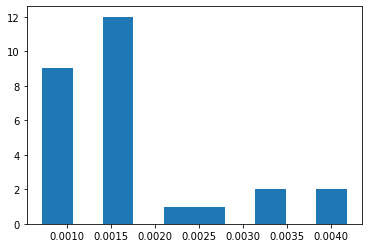

In [47]:
gradtestnp=gradtest[0].cpu().detach().numpy()
plt.hist(np.std(gradtestnp[np.sum(gradtestnp,1)!=0],axis=1))

(array([2., 1., 1., 0., 6., 1., 5., 0., 6., 5.]),
 array([-1.85907789e-04, -1.68891653e-04, -1.51875516e-04, -1.34859380e-04,
        -1.17843236e-04, -1.00827092e-04, -8.38109554e-05, -6.67948188e-05,
        -4.97786787e-05, -3.27625385e-05, -1.57464001e-05], dtype=float32),
 <BarContainer object of 10 artists>)

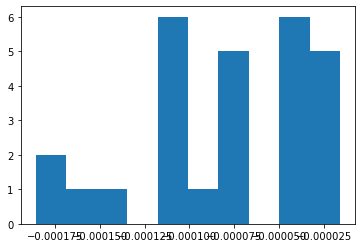

In [51]:
plt.hist(np.mean(gradtestnp[np.sum(gradtestnp,1)!=0],axis=1))